In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(N=[1000, 2000, 4000, 8000])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [32]:
#Network size
N = 4000
#Random connectivity
g = 3.8
J = g * np.random.normal(0, 1/np.sqrt(N), (N, N))

f_modes = 0.05
K = int(f_modes * N)
U = np.random.normal(0, 1/np.sqrt(N), (N, K))
VT = np.random.normal(0, 1/np.sqrt(N), (K, N))
g_eff = g
g = g_eff
S = np.ones(K)
S = g_eff * S / np.sqrt((S**2).sum()/N)
#J = np.einsum('ik, k, kj -> ij', U, S, VT)

#Structure
s = 2.6
sigma_diag = 1.6
sigma_off = 0.8
sigma_mn = np.array([[sigma_diag, -sigma_off],
                     [sigma_off, sigma_diag]])
sigma_mm = np.eye(2)
n_var = 4
sigma_nn = n_var * np.eye(2)

covariance_top = np.hstack([sigma_mm, sigma_mn])
covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
covariance = np.vstack([covariance_top, covariance_bot])

loadings = np.random.multivariate_normal(np.zeros(4), covariance, size=N)

m1 = loadings[:,0]/np.sqrt(N)
m2 = loadings[:,1]/np.sqrt(N)
n1 = loadings[:,2]/np.sqrt(N)
n2 = loadings[:,3]/np.sqrt(N)
M = np.multiply.outer(m1, n1) + np.multiply.outer(m2, n2)

#Recompute orthogonal m1 and m2 for analysis
#U, S, VT = np.linalg.svd(np.array([m1, m2]).T)
#m1 = U[:,0]
#m2 = U[:,1]
    
#Combine into one connectivity
W = J + s*M

In [33]:
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime = lambda x: np.exp(-(np.pi/4)*x**2)
phi_numpy = lambda x: erf((np.sqrt(np.pi)/2)*x)
def run_sim(T_sim, T_eval, dt, W, N_batch=1):
    device = W.device
    N = W.shape[0]
    eval_iter = int(T_eval / dt)
    Nt = int(T_sim / dt)
    N_save = int(T_sim / T_eval)
    #define stuff
    x_save = torch.zeros(N_save, N_batch, N, device=device)
    x = torch.randn(N_batch, N, device=device) * torch.std(W).item() * np.sqrt(N)
    x_save[0] = x
    r_lpf = x.clone()
    r_lpf_save = torch.zeros_like(x_save)
    r_lpf_save[0] = r_lpf
    #run
    for i in range(1, Nt):
        r = phi_torch(x)
        r_lpf += dt*(-r_lpf + r)
        x += dt*(-x + torch.mm(r, W.T))
        if i % eval_iter == 0:
            x_save[i//eval_iter] = x
            r_lpf_save[i//eval_iter] = r_lpf
    return x_save, r_lpf_save

In [34]:
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.05
dt_save = 1
x_save, r_lpf_save = run_sim(20000, dt_save, dt, W_)


In [35]:
T_initial = 500
x = x_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
psi_emp = phi_prime(x).mean(1)
phi_lpf = r_lpf_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
kappa_emp = phi_lpf.dot(np.array([n1, n2]).T)
Delta_emp = np.fft.irfft((np.abs(np.fft.rfft(x, axis=0, norm='ortho'))**2).mean(1))

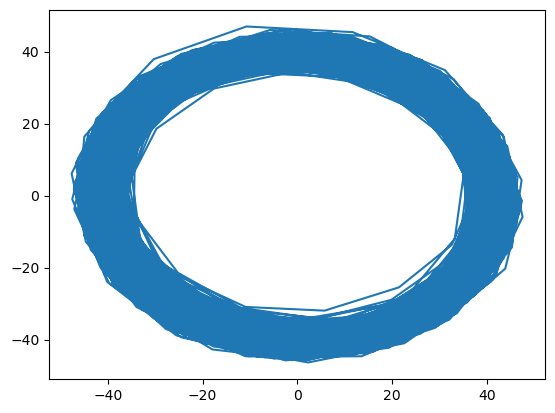

In [36]:
plt.plot(kappa_emp[:,0], kappa_emp[:,1])

In [37]:
r = phi_numpy(x)

In [38]:
cov = r.T.dot(r)/(r.shape[0] - 1)
eigs, vecs = np.linalg.eig(cov)

Text(0, 0.5, 'Normalized Var')

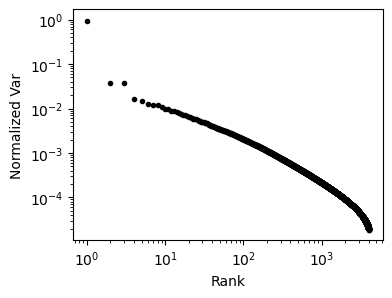

In [39]:
spec = sorted(np.abs(eigs))[::-1]
plt.figure(figsize=(4,3))
plt.plot(spec/np.abs(spec[0]), '.', color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Normalized Var')

In [ ]:
r_subset = r[:,:20]

In [ ]:
r_w = np.fft.rfft(r_subset, axis=0, norm='ortho')

In [ ]:
ccov_w = np.einsum('it, tj -> itj', np.conjugate(r_w.T), r_w)

In [ ]:
cross_covs = np.fft.irfft(ccov_w, axis=1)

In [ ]:
time_axis = np.arange(0, 50, dt_save)
fig, ax = plt.subplots(2, 1)
for i in range(20):
    for j in range(20):
        if i==j:
            col = 0
        else:
            col = 1
        ax[col].plot(time_axis, cross_covs[i, :len(time_axis), j], color='C{}'.format(col), alpha=0.4)
        ax[col].set_ylim([-1, 1])

In [ ]:
time_axis = np.arange(0, 50, dt_save)
fig, ax = plt.subplots(2, 1)
for i in range(20):
    for j in range(20):
        if i==j:
            col = 0
        else:
            col = 1
        ax[col].plot(time_axis, cross_covs[i, :len(time_axis), j], color='C{}'.format(col), alpha=0.4)
        ax[col].set_ylim([-1, 1])

In [ ]:
time_axis = np.arange(0, 50, dt_save)
fig, ax = plt.subplots(2, 1)
for i in range(20):
    for j in range(20):
        if i==j:
            col = 0
        else:
            col = 1
        ax[col].plot(time_axis, cross_covs[i, :len(time_axis), j], color='C{}'.format(col), alpha=0.02)
        ax[col].set_ylim([-1, 1])

In [ ]:
kappa_emp.shape

In [ ]:
phi_kappa = r.T.dot(kappa_emp)/(r.shape[0] - 1)

In [ ]:
f = np.fft.rfftfreq(kappa_emp.shape[0], dt_save)

In [ ]:
f.shape

In [ ]:
r_w = np.fft.rfft(r[:,:100], axis=0, norm='ortho')
k_w = (np.fft.rfft(kappa_emp, axis=0, norm='ortho').T * (1 + 1j * 2 * np.pi * f)).T

In [ ]:
ccov = np.einsum('it, tj -> itj', np.conjugate(r_w.T), k_w)

In [ ]:
ccov.shape

In [ ]:
autocovs = np.fft.irfft(ccov, axis=1)

In [ ]:
time_axis = np.arange(0, 800, dt_save)
for i in range(10):
    for j in range(2):
        plt.plot(time_axis, autocovs[i, :len(time_axis), j], color='C{}'.format(j))

In [ ]:
time_axis = np.arange(0, 200, dt_save)
for i in range(100):
    for j in range(2):
        plt.plot(time_axis, autocovs[i, :len(time_axis), j], color='C{}'.format(j), alpha=0.2)
plt.figure()
for j in range(2):
    plt.plot(time_axis, autocovs.mean(0)[:len(time_axis), j], color='C{}'.format(j))

In [ ]:
plt.plot(time_axis, Delta_emp[:len(time_axis)])

In [ ]:
processed_data = np.array(sorted(np.abs(eigs))[::-1])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'limit_cycles_torch_sims'
job_name = 'spectra_scaling_N_2'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

In [ ]:
job_id_1 = submit_job(job_script_path, n_jobs)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'spectra_scaling_N_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
for i in range(40):
    with open('../results/misc/spectra_scaling_N_2/result_{}'.format(i), 'rb') as f:
        res = pickle.load(f)
        
    new_res = np.zeros(8000)
    new_res[:len(res['processed_data'])] = res['processed_data']
    res['processed_data'] = new_res
    
    with open('../results/misc/spectra_scaling_N_2/result_{}'.format(i), 'wb') as f:
        pickle.dump(res, f)

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12, 2))
for i in range(4):
    N = configs_array['N'][i]
    for j in range(10):
        ax[i].plot(list(range(N)), results_array[i,j,:N], markersize=1, color='C0')
    ax[i].set_xlabel('Rank')
    #ax[i].set_xticks([0, N])
    ax[i].set_title('N = {}'.format(N))
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim([0.00001, 100000])

In [ ]:
fig, ax = plt.subplots(20, 20, figsize=(20, 20))
idx = [0, 1] + list(np.arange(2, 4000, 50))
for i in range(0, 20):
    for j in range(0, 20):
        ax[19-j,i].plot(idx, results_array[i,j,0,idx], '.', markersize=1)
        ax[19-j,i].set_ylim([-8, 6])
        ax[19-j,i].axis('off')
#ig.savefig('figs/g_s_log_spectra.pdf')

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(16, 4))
for i_ax in range(10):
    for i in range(4):
        for j in range(5):
            ax[i_ax].plot(configs_array['N'], results_array[:,i,i_ax, j], '.', color='C0', alpha=0.2)
    ax[i_ax].plot(configs_array['N'], 2/np.array(configs_array['N']), 'k')
    ax[i_ax].set_yscale('log')
    ax[i_ax].set_xlabel('N')
    ax[i_ax].set_xticks(configs_array['N'], ['2k', '4k', '8k'])
    ax[i_ax].set_ylim([0.0001, 0.3])
ax[0].set_title('Pure chaos')
ax[0].set_ylabel('PR x')
ax[-1].set_title('Pure structure')

In [ ]:
time_emp = np.arange(0, 25, 0.5)
for i in range(2):
    for j in range(6):
        for k in range(5):
            plt.plot(time_emp, results_array[i,j,k,:len(time_emp)]/results_array[i,j,k,0], color='C{}'.format(j),
                     alpha=0.5)

In [ ]:
v = results_array.squeeze()
plt.plot(configs_array['g'], v[:,0])
plt.plot(configs_array['g'], v[:,1], '.')
plt.xlabel('g')
plt.ylabel('x noise')
plt.title('s = 2.6')

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 1
for i in range(5):
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp)], color='C2')
    #ax[i].set_xticks([])
    ax[i].set_yticks([0, 1])
    ax[i].set_ylim([0, 1])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 5
for i in range(5):
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 0], color='C1')
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 1], color='C1')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))
#plt.ylim([0, 1])

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 4
for i in range(5):
    ax[i].plot(results_array[i, i_seed, :len(time_emp), 0], results_array[i, i_seed, :len(time_emp), 1], color='C1')
    #ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 1], color='C1')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))
#plt.ylim([0, 1])

In [ ]:
mft = run_low_rank_dmft(g=3.8, s=2.6, T=50, dt=0.01)
Delta = mft['Delta']

In [ ]:
plt.imshow(Delta)

In [ ]:
time_emp = np.arange(0, 25, 0.5)
time_mft = np.arange(0, 25, 0.01)
fig = plt.figure()
plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=1)
plt.plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])

In [ ]:
time_emp = np.arange(0, 25, 0.5)
time_mft = np.arange(0, 25, 0.01)
fig = plt.figure()
for i in range(50):
    Delta_emp = results_array[i]
    plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.1)
plt.plot(time_emp, results_array.mean(0)[:len(time_emp)], color='C1')
plt.plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
#plt.xlim(-1, 50)
plt.ylim([-14, 14])
plt.xlabel('$t - s$')
plt.ylabel('$\Delta(t, s)$')
plt.title('$N = 20k, g=3.8, s=2.6$')
#fig.savefig('figs/N=2k_theory_sim.pdf', dpi=300)
#plt.show()
#plt.plot(time_emp, kappa_emp[:len(time_emp)])
#plt.figure()
#plt.plot(time_mft, mft['kappa'][:len(time_mft)])

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
time_emp = np.arange(0, 25, 0.05)
time_mft = np.arange(0, 25, 0.025)
D = np.amax(np.abs(results_array))
for i_g, g in enumerate(np.arange(3, 5, 0.4)):
    for i_s_, s in enumerate(np.arange(1, 3, 0.4)):
        i_s = 4 - i_s_
        mft = run_low_rank_dmft(g=g, s=s, T=50, dt=0.025)
        Delta = mft['Delta']
        for i_seed in range(40):
            Delta_emp = results_array[i_s_, i_g, i_seed]
            ax[i_s, i_g].plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.05)
        ax[i_s, i_g].plot(time_emp, results_array[i_s_, i_g].mean(0)[:len(time_emp)], color='C1', linewidth=2)
        ax[i_s, i_g].plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
        #ax[i_s, i_g].axis('off')
        ax[i_s, i_g].set_ylim([-D, D])
        ax[i_s, 0].set_ylabel('s = {:0.1f}'.format(s))
        ax[4, i_g].set_xlabel('g = {:0.1f}'.format(g))
fig.savefig('figs/theory_sim_g35_s13.pdf')